## Plots graph edit distance figures stemoamide

In [16]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})

import numpy as np

In [17]:
def sum_abs_adj_matrix(m):
    return sum(sum(np.abs(m)))/2

### various graphing colors

In [18]:
# synthia graph colors
synthia_purple = np.array([80,50,145,255])/255
synthia_blue = np.array([45,190,205,255])/255
synthia_orange = np.array([255,160,0,255])/255
synthia_pink = np.array([235,60,150,255])/255

In [19]:
# chemdraw step marker colors
cdraw_orange_face = np.array([252,236,207,255])/255
cdraw_orange_edge = np.array([245,191,94,255])/255

In [20]:
# gridline color
grid_grey = np.array([225,225,225,255])/255

## initialize

In [21]:
def process_route(r1):
    
    """
    processes matrix-encoded synthetic route.
    
    input: r1, a 3D array, where each layer is a matrix encoding a synthetic intermediate.
    output: a dictionary of route metrics. 
        diffs - the graph edit distance from each intermediate to the target
        step diffs - the graph edit distance from each intermediate to the one right after
        slope - the difference between consecutive entries of the diffs array
    """
    total_diffs = []

    stereo_dists = []
    final_stereo = np.diag(r1[-1].copy())
    
    # get a version with blank diagonals (since stereochem is processed separately)
    final_bonds = r1[-1].copy()
    np.fill_diagonal(final_bonds, 0)
    
    for raw_mat in r1:
        
        # calculate stereochem distance 
        stereo_data = np.diag(raw_mat.copy())
        stereo_dist = sum(stereo_data != final_stereo)
        stereo_dists.append(stereo_dist)
        
        # get bonds only (without stereo)
        mat = raw_mat.copy()
        np.fill_diagonal(mat, 0)
        
        # bond distance
        diff = final_bonds - mat
        
        # get bond edit distance
        # take all absolute values, sum them up, divide by 2
        total_diff_abs = sum_abs_adj_matrix(diff)
        
        # append sum of bond and stereochem distance
        total_diffs.append(total_diff_abs + stereo_dist)

    
    step_diffs = []
    stereo_diffs = np.ediff1d(stereo_dists)
    for i_mat in range(len(r1)-1):
        # difference between 2 intermediates
        step_diff = r1[i_mat+1] - r1[i_mat]
        
        # zero out the stereochem 
        np.fill_diagonal(step_diff, 0)
        
        # total bond and stereocenter edits between 2 consecutive intermediates 
        total_diff_abs = sum_abs_adj_matrix(step_diff) + abs(stereo_diffs[i_mat])

        step_diffs.append(total_diff_abs)

    # change in actual distance between intermediates 
    slope = -np.ediff1d(total_diffs)

    return {"diffs":total_diffs,"step_diffs":step_diffs,"slopes":slope}
    

### load matrix data


In [22]:
exp1 = np.load("./matrices/stemo_exp_mannich.npz")["amats"]

syn1 = np.load("./matrices/stemo_synthia_mannich.npz")["amats"]

In [23]:
e1_data = process_route(exp1)

s1_data = process_route(syn1)

In [24]:
e1_data

{'diffs': [18.0, 7.0, 5.0, 5.0, 4.0, 2.0, 0.0],
 'step_diffs': [11.0, 2.0, 2.0, 3.0, 2.0, 2.0],
 'slopes': array([11.,  2., -0.,  1.,  2.,  2.])}

### plot graphs separately


the plotting code here is slightly raw. For a better-annotated function, see the notebook for plotting SI figures.

### Synthia Mannich route

In [25]:
to_plot = s1_data["diffs"]

In [26]:
y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
x_midpoints = np.arange(0.5,len(to_plot)-1,1)

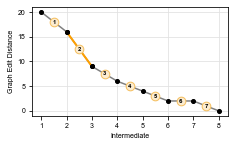

In [28]:
fig,ax = plt.subplots(figsize=(3.5,2))

mks = 4
fs = 7
label_fs = 7

# plot distances
ax.plot(to_plot,marker="o",color="grey",markersize=mks,mfc="k",mec="k")

# plot highlighted steps
ax.plot([1,2],to_plot[1:3],color=synthia_orange,marker="o",markersize=mks,mfc="k",mec="k",linewidth=2)


ax.set_xticks(range(len(to_plot)))
ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)
ax.set_yticks(range(0,21,5))
ax.set_yticklabels(range(0,21,5),fontsize=fs)
ax.set_ylabel("Graph Edit Distance",fontsize=label_fs)
ax.set_xlabel("Intermediate",fontsize=label_fs)

# for the yellow circles with step numbers.
# can adjust step number label height. can be array if custom adjustments are needed
y_adj = 0
ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

for i in range(len(x_midpoints)):
    x_c = x_midpoints[i]
    y_c = y_midpoints[i]+y_adj

    label = ax.annotate(i+1, xy=(x_c,y_c), fontsize=6,ha="center",va="center",fontweight="bold")

transX = ax.get_xaxis_transform()
transY = ax.get_yaxis_transform()
ax.vlines([1,3,5,7],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
ax.hlines([0,5,10,15,20],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

plt.savefig("./figures/synthia_mannich.svg",bbox_inches = "tight")

### Experimental Mannich route

In [29]:
to_plot = e1_data["diffs"]

In [30]:
y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
x_midpoints = np.arange(0.5,len(to_plot)-1,1)

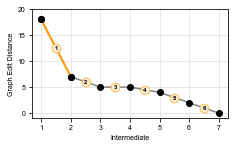

In [32]:
fig,ax = plt.subplots(figsize=(3.5,2))

mks = 4
fs = 7
label_fs = 7

ax.plot(e1_data["diffs"],marker="o",color="grey",markersize=1.5*mks,mfc="k",mec="k")
ax.plot([0,1],e1_data["diffs"][:2],color=synthia_orange,marker="o",markersize=1.5*mks,mfc="k",mec="k",linewidth=2)

ax.set_xticks(range(len(to_plot)))
ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)

ax.set_ylabel("Graph Edit Distance",fontsize=fs)
ax.set_xlabel("Intermediate",fontsize=fs)

transX = ax.get_xaxis_transform()
transY = ax.get_yaxis_transform()
ax.vlines([range(7)],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
ax.hlines([0,5,10,15],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

y_adj = 0
ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

for i in range(len(x_midpoints)):
    x_c = x_midpoints[i]
    y_c = y_midpoints[i]+y_adj
    
    label = ax.annotate(i+1, xy=(x_c,y_c), fontsize=6,ha="center",va="center",fontweight="bold")
    
ax.set_yticks(range(0,21,5))
ax.set_yticklabels(range(0,21,5),fontsize=fs)    

plt.savefig("./figures/exp_mannich.svg",dpi=300,bbox_inches = "tight")
pass